In [213]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline
plt.style.use('ggplot')

# from plots at the end -- TODO: try doing this only with PyTorch.
from scipy.stats import norm

import time

In [44]:
# Check if GPU is available
# !nvidia-smi
# print(torch.cuda.current_device())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()
# torch.cuda.is_available()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [110]:
seed = 2001  # tried seed: 1954, 1955, 1789

## Normal-normal model
We start with a normal model,
\begin{eqnarray*}
  p(\theta) & \propto & 1, \\
  p(z_i) & = & \text{normal}(0, 1), \\
  \Omega_\mu (z_i, \theta) & = & \theta + \tau z_i, \\
  p(x_i \mid z_i, \theta) & = & \text{normal}(\Omega_\mu(z_i, \theta), \sigma^2),
\end{eqnarray*}
with latent variables $(\theta, z_{1:n})$. This model admits a (non-trivial) analytical expression for the posterior distribution, which is a multivariate Gaussian.

In [111]:
# Generate observations from a hierarchical normal-normal model.
n = 10000
tau = 1.155
sigma = 2.43
x = np.random.normal(size = (n, 1), scale = np.sqrt(tau**2 + sigma**2))

To make fair comparisons between different VI, we pick starting values for the variational parameters, such that all methods start with the same initial ELBO.

In [324]:
def vi_init(seed, lock_init = True):
    # NOTE: it seems torch "updates" these values once they're passed to a model,
    # so we need to generate the inits multiple times (with the same seed)
    torch.manual_seed(seed)
    nu_mean_theta = torch.randn(1)
    nu_sd_theta_log = torch.randn(1)
    alpha0 = torch.zeros(1)  # torch.randn(1)  # torch.zeros((1, 1))
    alpha = torch.zeros(1)   # torch.randn(1)   # torch.zeros((1, 1))
    xi_log = torch.zeros(1)  # torch.randn(1)  # torch.zeros((1, 1))

    if (lock_init):
        nu_mean_z = (alpha0 + alpha * x).reshape(n)
        nu_sd_z_log = xi_log.repeat(n)
    else:
        nu_mean_z = torch.rand(n)
        nu_sd_z_log = torch.rand(n)
    
    return nu_mean_theta, nu_sd_theta_log, alpha0, alpha, nu_mean_z, nu_sd_z_log, xi_log


Define distributions to estimate the ELBO.

In [274]:
# Not vectorized, simpler version (i.e. assume only one Monte Carlo estimator)
def log_joint(x, theta, z):
    return -0.5 * torch.sum(z**2) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta - tau * z)**2)

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)
    return log_q_theta + log_q_z

In [275]:
# vectorized version for GPU
def log_joint_v(x, theta, z):
    return -0.5 * torch.sum(z**2, dim = 1) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta[:, None] - tau * z)**2, dim = 1)

def log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2,
                        dim = 1)
    return log_q_theta + log_q_z

### Factorized VI

In [325]:
# Tuning parameters for FVI
mc_samples = 100  # for Monte Carlo estimator of ELBO

In [326]:
class MCElbo_FVI(torch.nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 nu_mean_z_init, nu_sd_z_log_init):
        super(MCElbo_FVI, self).__init__()

        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = mc_samples

    def generate_rand(self, m):
        eps_theta = torch.randn(m).to(device)
        eps_z = torch.randn((m, n)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

    def compute_elbo(self, x):
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z)
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    self.nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)
        

In [327]:
def run_fvi(seed, n_iter_optimizer, lock_init = True, print_output = False):
    torch.manual_seed(seed)

    nu_mean_theta_init, nu_sd_theta_log_init, _alpha0, _alpha, nu_mean_z_init,\
        nu_sd_z_log_init, _xi_log = vi_init(seed, lock_init)

    model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init,
                       nu_sd_z_log_init).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    x_torch = Variable(torch.tensor(x), requires_grad = False).reshape(n)
    x_torch = x_torch.to(device) # move to GPU, if available

    n_iter_optimizer = int(5e3)
    loss_saved = torch.empty((n_iter_optimizer,))

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data
        if i % 1000  == 0 and print_output:
            print("loss", loss_saved[i])
    end_time = time.time()
    time_fvi = end_time - start_time
    return loss_saved, time_fvi


In [328]:
# Can run a single run and check output
if (False):
    loss_saved, time_fvi = run_fvi(seed, n_iter_optimizer)

    # Get final result from training model
    print("loss", loss.data)
    mf_mean_theta = model.nu_mean_theta.data
    mf_sd_theta = torch.exp(model.nu_sd_theta_log).data
    print(mf_mean_theta, mf_sd_theta)

    # Expected results for marginal posterior of theta
    print(np.mean(x))  # mean
    print(np.sqrt((tau**2 + sigma**2) / n))  # sd

    plt.plot(loss_saved)
    plt.yscale("log")
    plt.xscale("log")

###  Amortized VI
We consider AVI using a polynomial inference function of degree up to 2.
In the amortized family,
\begin{equation*}
  q(z_i; x_i) = \text{normal}(f_\mu(x_i, \eta), f_{\sigma^2}(x_i, \eta)),
\end{equation*}
where
\begin{eqnarray*}
  f_\mu(x_i, \eta) & = & \alpha_0 + \alpha x_i + \beta x_i^2 \\
  f_{\sigma^2}(x_i, \eta) & = & \eta_{\sigma^2},
\end{eqnarray*}
meaning we need to optimize over three variational parameters, $\eta = (\alpha_0, \alpha, \beta, \eta_{\sigma^2})$, regardless of what $n$ may be.

In [329]:
class MCElbo_AVI(torch.nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 alpha0_init, alpha_init, xi_log_init):
        super(MCElbo_AVI, self).__init__()
        
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.alpha0 = torch.nn.Parameter(alpha0_init, requires_grad = True)
        self.alpha = torch.nn.Parameter(alpha_init, requires_grad = True)
        self.beta = torch.nn.Parameter(torch.zeros((1, 1)), requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(xi_log_init, requires_grad = True)
        
        self.mc_samples = mc_samples
        
   
    def generate_rand(self, m):
        eps_theta = torch.randn(m).to(device)
        eps_z = torch.randn((m, n)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z, x, nu_mean_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(nu_mean_z)

    def compute_elbo_sample(self, x, nu_mean_z):
        eps_theta, eps_z = self.generate_rand()
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)

        elbo = log_joint(x, theta, z) - log_q(theta, z, self.nu_mean_theta,
                                              torch.exp(self.nu_sd_theta_log),
                                              nu_mean_z,
                                              torch.exp(self.nu_sd_z_log))
        return elbo        
    
    def compute_elbo(self, x, poly_degree):
        if (poly_degree == 0):
            nu_mean_z = self.alpha0
        if (poly_degree == 1):
            nu_mean_z = self.alpha0 + self.alpha.mul(x)
        if (poly_degree == 2):
            nu_mean_z = self.alpha0 + self.alpha.mul(x) + self.beta.mul(x**2)
        
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)
        
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)        


In [330]:
def run_avi(poly_degree, seed, n_iter_optimizer, lock_init = True, print_output = False):
    torch.manual_seed(seed)
    nu_mean_theta_init, nu_sd_theta_log_init, alpha0_init, alpha_init,\
    __mean_z, _nu_sd_z_log, xi_log_init = vi_init(seed, lock_init)

    model_av = MCElbo_AVI(nu_mean_theta_init, nu_sd_theta_log_init,
                          alpha0_init, alpha_init, xi_log_init).to(device)
    optimizer = torch.optim.Adam(model_av.parameters(), lr = 1e-2)

    loss_av_saved = torch.empty((n_iter_optimizer,))

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss_av = - model_av.compute_elbo(x_torch, poly_degree)
        optimizer.zero_grad()
        loss_av.backward()
        optimizer.step()
        loss_av_saved[i] = loss_av.data
        if i % 1000 == 0 and print_output:
            print("loss", loss_av.data)
    end_time = time.time()
    return loss_av_saved, end_time - start_time


In [ ]:
# DRAFT CODE when running 

# seed = 1989
# loss_saved, time_fvi = run_fvi(seed, n_iter_optimizer)
# loss_avi_0_saved, time_avi_0 = run_avi(0, seed, n_iter_optimizer)
# loss_avi_1_saved, time_avi_1 = run_avi(1, seed, n_iter_optimizer)
# loss_avi_2_saved, time_avi_2 = run_avi(2, seed, n_iter_optimizer)

# save loss functions to csv
# n_algorithms = 4
# loss_all = torch.empty((n_iter_optimizer, n_algorithms))

# loss_all[:, 0] = loss_saved
# loss_all[:, 1] = loss_avi_0_saved
# loss_all[:, 2] = loss_avi_1_saved
# loss_all[:, 3] = loss_avi_2_saved

# np.save("deliv/lin_loss_" + str(seed), loss_all.detach().numpy())

# saved_times = np.array([time_fvi, time_avi_0, time_avi_1, time_avi_2])
# np.save("deliv/lin_time_" + str(seed), saved_times)


In [331]:
# function to run the experiments over multiple seeds
def run_experiment(seed, n_iter_optimizer, lock_init):
    loss_fvi, time_fvi = run_fvi(seed, n_iter_optimizer, lock_init)
    loss_avi_0_saved, time_avi_0 = run_avi(0, seed, n_iter_optimizer, lock_init)
    loss_avi_1_saved, time_avi_1 = run_avi(1, seed, n_iter_optimizer, lock_init)
    loss_avi_2_saved, time_avi_2 = run_avi(2, seed, n_iter_optimizer, lock_init)

    n_algorithms = 4
    loss_all = torch.empty((n_iter_optimizer, n_algorithms))

    loss_all[:, 0] = loss_fvi
    loss_all[:, 1] = loss_avi_0_saved
    loss_all[:, 2] = loss_avi_1_saved
    loss_all[:, 3] = loss_avi_2_saved

    np.save("deliv/lin_loss_" + str(seed) + "_lock" + str(lock_init), loss_all.detach().numpy())

    saved_times = np.array([time_fvi, time_avi_0, time_avi_1, time_avi_2])
    np.save("deliv/lin_time_" + str(seed) + "_lock" + str(lock_init), saved_times)


In [332]:
init_seed = 1954

for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, n_iter_optimizer, lock_init = False)


seed:  1954
seed:  1955
seed:  1956
seed:  1957
seed:  1958
seed:  1959
seed:  1960
seed:  1961
seed:  1962
seed:  1963


### Analyze results

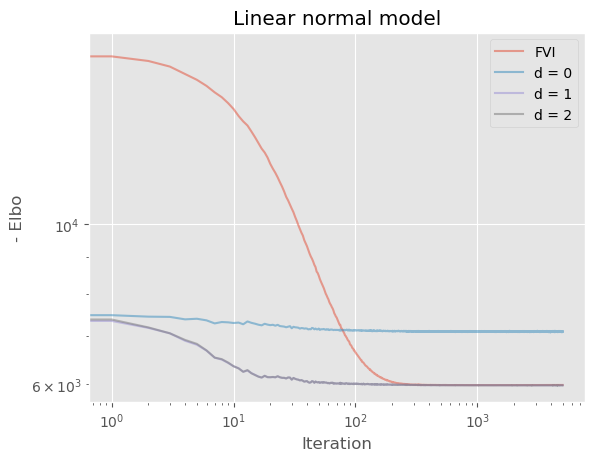

In [402]:
# read saved input
seed = 1959
lock_init = False
loss_all = np.load("deliv/lin_loss_" + str(seed) + "_lock" + str(lock_init) + ".npy")
# CHECK -- is it ok to use pickle = True

loss_saved = loss_all[:, 0]
loss_avi_0_saved = loss_all[:, 1]
loss_avi_1_saved = loss_all[:, 2]
loss_avi_2_saved = loss_all[:, 3]


# plt.plot(loss_saved, label = 'mean field')
plt.plot(loss_saved, label = 'FVI', alpha = 0.5)
plt.plot(loss_avi_0_saved, label = 'd = 0', alpha = 0.5)
plt.plot(loss_avi_1_saved, label = 'd = 1', alpha = 0.5)
plt.plot(loss_avi_2_saved, label = 'd = 2', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.title("Linear normal model")
plt.xlabel("Iteration")
plt.ylabel("- Elbo")

# ax = plt.axes()
# ax.set_facecolor("white")
# ax.grid(which = 'major', b = 'true', c = 'grey')
plt.savefig("to_discuss/elbo_lin_normal_" + str(seed) + ".pdf")
plt.show()


In [345]:
# Examine the coefficients of the trained inference polynomials
print(model_avi_0.alpha0.data, model_avi_0.alpha.data, model_avi_0.beta.data)
print(model_avi_1.alpha0.data, model_avi_1.alpha.data, model_avi_1.beta.data)
print(model_avi_2.alpha0.data, model_avi_2.alpha.data, model_avi_2.beta.data)

tensor([[-0.0037]], device='cuda:0') tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0')
tensor([[-0.0070]], device='cuda:0') tensor([[0.1598]], device='cuda:0') tensor([[0.]], device='cuda:0')
tensor([[-0.0043]], device='cuda:0') tensor([[0.1599]], device='cuda:0') tensor([[-0.0006]], device='cuda:0')


In [403]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 

In [404]:
# Get asymptotic ELBO
index_center = 4500
window = 500
print("FVI: ", mean_window(loss_saved, 4500, window), " +/- ",
     sd_window(loss_saved, 4500, window))
print("d = 0: ", mean_window(loss_avi_0_saved, 4500, window), " +/- ",
     sd_window(loss_avi_0_saved, 4500, window))
print("d = 1: ", mean_window(loss_avi_1_saved, 4500, window), " +/- ",
     sd_window(loss_avi_1_saved, 4500, window))
print("d = 2: ", mean_window(loss_avi_2_saved, 4500, window), " +/- ",
     sd_window(loss_avi_2_saved, 4500, window))

FVI:  5978.872  +/-  0.35648352
d = 0:  7091.83  +/-  4.7424726
d = 1:  5973.0186  +/-  0.07557278
d = 2:  5973.185  +/-  0.29985538


In [431]:
## Estimate of the convergence
# If oracle = False, compare subsequent windows.
def iter_convergence(loss, rel_tol = 0.01, init_iteration = 10, window = 10,
                     grid = 10, max_iteration = 5000, oracle = True, set_target = 0):
    iteration = init_iteration
    tol = 0
    diff = tol + 1
    while(diff > tol and iteration < max_iteration):
        iteration += grid
        if (oracle):
            target = set_target
        else:
            target = mean_window(loss, iteration - grid, window)

        tol = rel_tol * abs(target)
        diff = abs(mean_window(loss, iteration, window) - target)
        # print("diff:", diff)
        # print("tol:", tol)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual solution?
def iter_conv_wrapper(loss, loss_benchmark, rel_tol = 0.01, window = 10):
    return iter_convergence(loss, oracle = True, rel_tol = rel_tol,
                            set_target = mean_window(loss_benchmark, 4500, window))


In [430]:
print("FVI:", iter_conv_wrapper(loss_saved, loss_saved))
print("d = 0:", iter_conv_wrapper(loss_avi_0_saved, loss_saved))
print("d = 1:", iter_conv_wrapper(loss_avi_1_saved, loss_saved))
print("d = 2:", iter_conv_wrapper(loss_avi_2_saved, loss_saved))


FVI: 200
d = 0: 5000
d = 1: 50
d = 2: 50


In [447]:
# Get results across multiple seeds
init_seed = 1954
num_seed = 10
lock_init = False  # Both options have saved files
num_seed = 10
n_algorithms = 4
num_tol = 3
rel_tol = np.array([0.5, 0.1, 0.01])

iter_to_conv = np.empty((num_seed, n_algorithms, num_tol))
Elbo_final = np.empty((num_seed, n_algorithms)) 

for i in range(num_seed):
    loss_all = np.load("deliv/lin_loss_" + str(init_seed + i) + "_lock" + str(lock_init) + ".npy")

    for j in range(n_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:, j], 4500, window)
        for k in range(num_tol):
            # Use F-VI as the benchmark for the asymptotic ELBO
            iter_to_conv[i, j, k] = iter_conv_wrapper(loss_all[:, j], loss_all[:, 0], rel_tol[k])


In [448]:
print("mean iter:\n", np.mean(iter_to_conv, axis = 0))
print("min iter:\n", np.min(iter_to_conv, axis = 0))
print("max iter:\n", np.max(iter_to_conv, axis = 0))
print(np.mean(Elbo_final, axis = 0))

mean iter:
 [[  73.  184.  590.]
 [  54. 5000. 5000.]
 [  40.  126.  507.]
 [  40.  126.  508.]]
min iter:
 [[  50.  110.  200.]
 [  20. 5000. 5000.]
 [  20.   20.   20.]
 [  20.   20.   20.]]
max iter:
 [[ 170.  510. 1920.]
 [ 220. 5000. 5000.]
 [ 160.  510. 1890.]
 [ 160.  510. 1890.]]
[5980.44077148 7093.1487793  5974.60620117 5974.76279297]


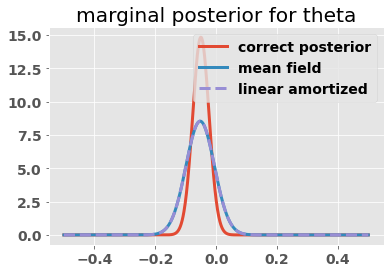

In [26]:
xn = np.arange(-0.5, 0.5, 0.001)
true_dist = norm(loc = np.mean(x),
                scale = np.sqrt((tau**2 + sigma**2) / n))

q_mf_dist = norm(loc = mf_mean_theta,
                 scale = mf_sd_theta)

q_am_dist = norm(loc = model.nu_mean_theta.data.numpy(),
                 scale = torch.exp(model.nu_sd_theta_log).data.numpy())

plt.plot(xn, true_dist.pdf(xn).ravel(), linewidth = 3, label = "correct posterior")
plt.plot(xn, q_mf_dist.pdf(xn).ravel(), linewidth = 3, label = "mean field")
plt.plot(xn, q_am_dist.pdf(xn).ravel(), '--', linewidth = 3, label = "linear amortized")
plt.title("marginal posterior for theta")
plt.legend()
plt.savefig("to_discuss/marginal_theta.pdf")
plt.show()

## ToDo: examine other marginal, and maybe some joints...

# Normal-Normal with unknown prior variance
Same model as before, but this time the prior variance is unknown. This slight complication of the model means we no longer have access to analytical solutions.
\begin{eqnarray*}
  p(\theta) & \propto & 1, \\
  p(\tau) & = & \text{log-norma}(0, 1), \\
  p(z_i) & = & \text{normal}(0, 1), \\
  \Omega_\mu (z_i, \theta) & = & \theta + \tau z_i, \\
  p(x_i \mid z_i, \theta) & = & \text{normal}(\Omega_\mu(z_i, \theta), \sigma^2),
\end{eqnarray*}

Notes: 
* Can re-use the data simulated in the previous section.
* Since we operate on the unconstrained scale, the model is parameterized in terms of $p(\log \tau) = \text{normal}(0, 1)$.

### Mean field VI

In [ ]:
# Common initializations
torch.manual_seed(1954)
nu_mean_theta_init = torch.randn(1, 1)
nu_sd_theta_log_init = torch.randn(1, 1)
nu_mean_log_tau_init = torch.randn(1, 1)
nu_sd_log_tau_log_init = torch.randn(1, 1)
alpha0_init = torch.randn(1, 1)
alpha_init = torch.randn(1, 1)
nu_mean_z_init = alpha0_init + alpha_init * x

nu_sd_z_log_init = torch.randn(1, 1)

In [ ]:
def log_joint(x, theta, log_tau, z):
    return -0.5 * torch.sum(z**2) - 1 / (2 * sigma**2)\
               * torch.sum((x - theta - z)**2)\
               - 0.5 * log_tau**2

def log_q(theta, log_tau, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z,
          nu_mean_log_tau, nu_sd_log_tau):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    
    log_q_tau = - torch.log(nu_sd_log_tau) - 1 / (2 * nu_sd_log_tau**2)\
                                                       * (log_tau - nu_mean_log_tau)**2

    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)

    return log_q_theta + log_q_tau + log_q_z

In [ ]:
class MCElbo_meanfield_nnt(torch.nn.Module):
    def __init__(self):
        super(MCElbo_meanfield_nnt, self).__init__()
        
        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_log_tau = torch.nn.Parameter(nu_mean_log_tau_init, requires_grad = True)
        self.nu_sd_log_tau_log = torch.nn.Parameter(nu_sd_log_tau_log_init,
                                                    requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = 50

    def generate_rand(self):
        eps_theta = np.random.normal(size = (1, 1))
        eps_tau_log = np.random.normal(size = (1, 1))
        eps_z = np.random.normal(size = (n, 1))

        return eps_theta, eps_tau_log, eps_z
        
    def reparam(self, eps_theta, eps_log_tau, eps_z):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_log_tau = Variable(torch.FloatTensor(eps_log_tau))
        eps_z = Variable(torch.FloatTensor(eps_z))
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_log_tau.mul(torch.exp(self.nu_sd_log_tau_log)).add(self.nu_mean_log_tau),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)
    
    def compute_elbo_sample(self, x):
        eps_theta, eps_log_tau, eps_z = self.generate_rand()
        theta, log_tau, z = self.reparam(eps_theta, eps_log_tau, eps_z)
        Elbo = log_joint(x, theta, log_tau, z)\
               - log_q(theta, log_tau, z,
                         self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                         self.nu_mean_z, torch.exp(self.nu_sd_z_log),
                         self.nu_mean_log_tau, torch.exp(self.nu_sd_log_tau_log))
        return Elbo

    def compute_elbo(self, x):
        Elbo_mean = self.compute_elbo_sample(x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)
        
        return Elbo_mean
    

In [ ]:
model = MCElbo_meanfield_nnt()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
x_torch = Variable(torch.tensor(x), requires_grad = False)

n_iter_optimizer = int(5e3)
loss_saved = np.empty((n_iter_optimizer,))

for i in range(n_iter_optimizer):
    loss = - model.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_saved[i] = loss.data.numpy()
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model.nu_mean_theta.data.numpy(), torch.exp(model.nu_sd_theta_log).data.numpy())
        print(model.nu_mean_log_tau.data.numpy(), model.nu_sd_log_tau_log.data.numpy())


In [ ]:
# Get final result from training model
print("loss", loss.data.numpy())
mf_mean_theta = model.nu_mean_theta.data.numpy()
mf_sd_theta = torch.exp(model.nu_sd_theta_log).data.numpy()
print(mf_mean_theta, mf_sd_theta)

# Expected results for marginal posterior of theta
print(np.mean(x))  # mean
print(np.sqrt((tau**2 + sigma**2) / n))  # sd

In [ ]:
plt.plot(loss_saved)
plt.yscale("log")
plt.xscale("log")

### Linear Amortized VI

In [ ]:
# Common initializations
torch.manual_seed(1954)
nu_mean_theta_init = torch.randn(1, 1)
nu_sd_theta_log_init = torch.randn(1, 1)
nu_mean_log_tau_init = torch.randn(1, 1)
nu_sd_log_tau_log_init = torch.randn(1, 1)
alpha0_init = torch.randn(1, 1)
alpha_init = torch.randn(1, 1)
nu_mean_z_init = alpha0_init + alpha_init * x

nu_sd_z_log_init = torch.randn(1, 1)

In [ ]:
def log_amortized_q(theta, log_tau, z, nu_mean_theta, nu_sd_theta, nu_mean_log_tau,
                    nu_sd_log_tau, alpha0, alpha, nu_sd, x):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    
    # log_q_tau = 0
    log_q_tau = - torch.log(nu_sd_log_tau) - 1 / (2 * nu_sd_log_tau**2)\
                                                       * (log_tau - nu_mean_log_tau)**2
    
    log_q_z = torch.sum(- torch.log(nu_sd) - 1 / (2 * nu_sd**2) * (z - alpha0 - alpha * x)**2)
    
    return log_q_theta + log_q_tau + log_q_z


In [ ]:
class MCElbo_linear_arm_nnt(torch.nn.Module):
    def __init__(self):
        super(MCElbo_linear_arm_nnt, self).__init__()

        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_log_tau = torch.nn.Parameter(nu_mean_log_tau_init, requires_grad = True)
        self.nu_sd_log_tau_log = torch.nn.Parameter(nu_sd_log_tau_log_init,
                                                    requires_grad = True)
        self.alpha0 = torch.nn.Parameter(alpha0_init, requires_grad = True)
        self.alpha = torch.nn.Parameter(alpha_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)
        
        self.mc_samples = 50

    def generate_rand(self):
        eps_theta = np.random.normal(size = (1, 1))
        eps_tau_log = np.random.normal(size = (1, 1))
        eps_z = np.random.normal(size = (n, 1))
        return eps_theta, eps_tau_log, eps_z

    def reparam(self, eps_theta, eps_tau_log, eps_z, x):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_log_tau = Variable(torch.FloatTensor(eps_tau_log))
        eps_z = Variable(torch.FloatTensor(eps_z))

        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_log_tau.mul(torch.exp(self.nu_sd_log_tau_log)).add(self.nu_mean_log_tau),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.alpha0).add(self.alpha.mul(x))        

    def compute_elbo_sample(self, x):
        eps_theta, eps_log_tau, eps_z = self.generate_rand()
        theta, log_tau, z = self.reparam(eps_theta, eps_log_tau, eps_z, x)
        
        elbo = log_joint(x, theta, log_tau, z)\
          - log_amortized_q(theta, log_tau, z,
                            self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                            self.nu_mean_log_tau, torch.exp(self.nu_sd_log_tau_log),
                            self.alpha0, self.alpha, torch.exp(self.nu_sd_z_log), x)        
        return elbo

    def compute_elbo(self, x):
        Elbo_mean = self.compute_elbo_sample(x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)
        return Elbo_mean


In [ ]:
model_arm = MCElbo_linear_arm_nnt()

optimizer = torch.optim.Adam(model_arm.parameters(), lr = 1e-2)
x_torch = Variable(torch.tensor(x), requires_grad = False)

n_iter_optimizer = int(5e3)  # 5e3
loss_am_saved = np.empty(n_iter_optimizer)
for i in range(n_iter_optimizer):
    loss = - model_arm.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_am_saved[i] = loss
    if i % 1000  == 0:
        print("loss", loss.data.numpy())
        print(model_arm.nu_mean_theta.data.numpy(),
              torch.exp(model_arm.nu_sd_theta_log).data.numpy())
        

In [ ]:
# "Final" result
print("loss", loss.data.numpy())
print(model_arm.nu_mean_theta.data.numpy(), torch.exp(model_arm.nu_sd_theta_log).data.numpy())

# Expected results for marginal posterior of theta
print(np.mean(x))
print(np.sqrt((tau**2 + sigma**2) / n))

In [ ]:
plt.plot(loss_am_saved, label = 'linear amortized', alpha = 0.5)
plt.plot(loss_saved, label = 'mean field', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.title("Elbo, n = " + str(n))
plt.savefig("to_discuss/elbo.pdf")
plt.show()

In [ ]:
mf_means = [model.nu_mean_theta.data.numpy(),
            model.nu_mean_log_tau.data.numpy(),
            model.nu_mean_z.data.numpy()[0]]

mf_sd = [torch.exp(model.nu_sd_theta_log).data.numpy(),
         torch.exp(model.nu_sd_log_tau_log).data.numpy(),
         torch.exp(model.nu_sd_z_log[0]).data.numpy()]

arm_means = [model_arm.nu_mean_theta.data.numpy(),
             model_arm.nu_mean_log_tau.data.numpy(),
             model_arm.alpha0.data.numpy() + model_arm.alpha.data.numpy() * x[0]]

arm_sd = [torch.exp(model_arm.nu_sd_theta_log).data.numpy(),
          torch.exp(model_arm.nu_sd_log_tau_log).data.numpy(),
          torch.exp(model_arm.nu_sd_z_log).data.numpy()]


In [ ]:
# TODO: get a benchmark (e.g. with long MCMC runs...)
xn = np.arange(-2.5, 2.5, 0.001)
# true_dist = norm(loc = np.mean(x),
#                 scale = np.sqrt((tau**2 + sigma**2) / n))

index = 2

q_mf_dist = norm(loc = mf_means[index], scale = mf_sd[index])
q_am_dist = norm(loc = arm_means[index], scale = arm_sd[index])


# plt.plot(xn, true_dist.pdf(xn).ravel(), linewidth = 3, label = "correct posterior")
plt.plot(xn, q_mf_dist.pdf(xn).ravel(), linewidth = 3, label = "mean field")
plt.plot(xn, q_am_dist.pdf(xn).ravel(), '--', linewidth = 3, label = "linear amortized")
plt.title("marginal posterior for theta")
plt.legend()
plt.savefig("to_discuss/marginal_theta.pdf")
plt.show()

# Draft Code

In [ ]:
# Test code...
theta = torch.normal(mean = torch.mean(x_torch).repeat(10, 1), std = 1)
z = torch.normal(mean = torch.tensor([0.]).repeat(10, 1), std = 2.3)

nu_mean_theta = torch.tensor([np.mean(x)])
nu_sd_theta = torch.tensor([2.1])
alpha0 = torch.tensor([np.mean(x)])
alpha = torch.tensor([0.2])
nu_sd = torch.tensor([0.8])

x_torch = torch.tensor(x)[:,0].repeat(10, 1)

log_am_q = log_amortized_q(theta, z, nu_mean_theta, nu_sd_theta, alpha0, alpha, nu_sd, x_torch)
print(log_am_q.size())

In [ ]:
alpha0 = torch.randn(1,)
alpha = torch.randn(1,)
test_mean = (alpha0 + alpha * x_torch).repeat(100, 1, 1).reshape(100, 5)
print(alpha0.size())
print((alpha * x_torch).size())
print(test_mean.size())

In [ ]:
# draft code
test_mean = torch.tensor([0., 10, 1, 0., -1.])
test_sd = torch.tensor([1])
print(torch.normal(mean = test_mean, std = test_sd))

test_mean_theta = torch.tensor([0.])
test_sd_theta = torch.tensor([1.])
print(torch.normal(mean = test_mean_theta, std = test_sd_theta))

test_mean_repeat = test_mean.repeat(10, 1)  # Check -- should I use expand instead?
print(test_mean_repeat)

samples_repeat = torch.normal(mean = test_mean_repeat, std = test_sd)
print(samples_repeat.size())

samples_repeat_theta = torch.normal(mean = test_mean_theta.repeat(10, 1),
                                    std = test_sd_theta)
print(samples_repeat_theta.size())

print(torch.tensor(x)[:,0].size())
print(test_mean.size())
x_torch = torch.tensor(x)[:,0].repeat(10, 1)
x_torch.size()

print("theta sample size", samples_repeat_theta.size())
print(samples_repeat.size())
x_torch = torch.tensor(x)[:,0].repeat(10, 1)
print(x_torch.size())
f = log_joint(x_torch, samples_repeat_theta, samples_repeat)

print("f size:", f.size())
print(f)
print(torch.mean(f))

f_q = log_q(samples_repeat_theta, samples_repeat, test_mean_theta, 
            test_sd_theta, test_mean, test_sd)

print("f_q size:", f_q.size())
# print(f_q)
print(torch.mean(f_q))

print(samples_repeat.size())
print(test_mean.repeat(1, 1).size())

nu_sd_z = test_sd
nu_mean_z = test_mean.repeat(1, 1)
z = samples_repeat
kernel = - torch.sum(1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2, dim = 1)
kernel.size()

kernel = - 1 / (2 * test_sd_theta**2) * (samples_repeat_theta - test_mean_theta)**2
kernel.size()

### Draft code to test vectorized version of log density evaluation

In [ ]:
# Test vectorized density computation
x_torch = Variable(torch.tensor(x), requires_grad = False)
x_torch2 = x_torch.reshape(10000)
print(x_torch2.shape)
theta = torch.randn(100)
print(theta.shape)
z = torch.randn(100, n)
print(z.shape)

nu_mean_theta = torch.randn(1)
nu_sd_theta = torch.exp(torch.randn(1))
nu_mean_z = torch.randn(n)
nu_sd_z = torch.exp(torch.randn(n))


lq_v = log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
print(lq_v[0])

lq_ = log_q(theta[0], z[0,:], nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
print(lq_)

lp_v = log_joint_v(x_torch2, theta, z)
print(lp_v[0])

lp_ = log_joint(x_torch2, theta[0], z[0,:])
print(lp_)

z_sum = torch.sum(z**2, dim = 1)
print(z_sum.shape)
print(z_sum[0])
print(torch.sum(z[0,:]**2))

mean = x_torch2 - theta[:, None] - tau * z
print(mean.shape)
print(mean[0,:])

mean_0 = x_torch2 - theta[0] - tau * z[0, :]
print(mean_0)

mean_sum = torch.sum(mean, dim = 1)
print(mean_sum.shape)
print(mean_sum[0])

x_torch2 = x_torch.reshape(10000)
print(x_torch2.shape)
print((tau * z).shape)
a = x_torch2 - (tau * z)
print(a.shape)

m = 100
eps_theta = np.random.normal(size = m)
eps_z = np.random.normal(size = (m, n))

nu_sd_theta_log = torch.randn(1)
nu_mean_theta = torch.randn(1)
nu_sd_z_log = torch.randn(n)
nu_mean_z = torch.randn(n)

eps_theta = Variable(torch.FloatTensor(eps_theta))
eps_z = Variable(torch.FloatTensor(eps_z))

# eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

a = eps_theta.mul(torch.exp(nu_sd_theta_log)).add(nu_mean_theta)
b = eps_z.mul(torch.exp(nu_sd_z_log)).add(nu_mean_z)
print(a.shape)
print(b.shape)